In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Triangulation Functions

In [2]:
def triangulate_point(ptsl,ptsr,Pl,Pr):
    # Point pair triangulation from least squares solution.

    # Prepare system of equations
    M = np.zeros((6,6))
    M[:3,:4] = Pl
    M[3:,:4] = Pr
    M[:3,4] = -ptsl
    M[3:,5] = -ptsr

    # Perform SVD to find the 3D coordinate
    U,S,V = np.linalg.svd(M)
    X = V[-1,:4]
    Y = V[-1]

    return X / X[3]


def triangulate(ptsl,ptsr,Pl,Pr):
    # Two-view triangulation of points in x1,x2 (3*n homog. coordinates).

    n = ptsl.shape[1]
    if ptsr.shape[1] != n:
      raise ValueError("Number of points don't match.")

    # Call the triangulate function to each pair of points
    X = [ triangulate_point(ptsl[:,i],ptsr[:,i],Pl,Pr) for i in range(n)]

    return np.array(X).T

#Example

In [3]:
data_path = './'


def case1():

  # Read images
  img1 = cv2.imread(data_path + '001.jpg') #left image
  img2 = cv2.imread(data_path + '002.jpg') #right image

  img_left = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
  img_right = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)


  # Read points from file
  points2D = [np.loadtxt(data_path+'00'+str(i+1)+'.corners').T for i in range(2)]
  # Load correspondences
  corr = np.genfromtxt(data_path+'nview-corners',dtype='int',missing_values='*')

  # Index for points in first two views
  ndx = (corr[:,0]>=0) & (corr[:,1]>=0)

  # Get coordinates and make homogeneous
  pts_left = points2D[0][:,corr[ndx,0]]
  pts_left = np.vstack( (pts_left,np.ones(pts_left.shape[1])) )
  pts_right = points2D[1][:,corr[ndx,1]]
  pts_right = np.vstack( (pts_right,np.ones(pts_right.shape[1])) )

  # Load 3D points
  points3D = np.loadtxt(data_path+'p3d').T
  P3D_true = points3D[:,ndx]
  P3D_true = np.vstack( (P3D_true,np.ones(P3D_true.shape[1])) )

  # Load the projection matrix of each camera (left and right)
  M = [np.loadtxt(data_path+'00'+str(i+1)+'.P') for i in range(2)]
  M_left = M[0]
  M_right = M[1]

  return img_left, img_right, pts_left, pts_right, M_left, M_right, P3D_true


def case2():

  # Read images
  img1 = cv2.imread(data_path +'left.ppm')  # left image
  img2 = cv2.imread(data_path +'right.ppm') # right image

  img_left = img1
  img_right = img2

  #img_left = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
  #img_right = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

  # Intrinsic parameter matrix
  fm = 403.657593 # Fical distantce in pixels
  cx = 161.644318 # Principal point - x-coordinate (pixels)
  cy = 124.202080 # Principal point - y-coordinate (pixels)

  # for the right camera
  Kr = np.array([[ fm, 0, cx],[0, fm, cy],[0, 0, 1.0000]])

  # for the left camera
  Kl = np.array([[fm, 0, cx],[0, fm, cy],[0, 0, 1.0000]])

  # Extrinsec parameters
  # Translation between cameras
  bl = 119.929 # baseline (mm)
  T = np.array([-bl, 0, 0]).reshape(3,1)
  # Rotation - there is no rotation between cameras
  # It is a rectified system
  R = np.array([[ 1,0,0],[ 0,1,0],[0,0,1]])

  # Define the projection matrix of each camera (left and right)
  M_left = Kl @ np.eye(3,4)
  M_right = Kr @ np.hstack((R,T))

  # Find the keypoints and descriptors with SIFT
  sift = cv2.SIFT_create(1000)
  #sift = cv2.xfeatures2d.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img_left,None)
  kp2, des2 = sift.detectAndCompute(img_right,None)

  # Solve matching between detected points in both images
  # FLANN parameters
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks=10)
  flann = cv2.FlannBasedMatcher(index_params,search_params)
  matches = flann.knnMatch(des1,des2,k=2)
  good = []
  pts_left = []
  pts_right = []

  # Select good matches
  # ratio test as per Lowe's paper
  for i,(m,n) in enumerate(matches):

      if m.distance < 0.75*n.distance:
          good.append(m)
          pts_left.append(kp1[m.queryIdx].pt)
          pts_right.append(kp2[m.trainIdx].pt)

  # Define good points from left and right images
  # These points will be used for 3D reconstruction

  pts_left = np.int32(pts_left).T
  pts_left = np.vstack( (pts_left,np.ones(pts_left.shape[1])) )
  pts_right = np.int32(pts_right).T
  pts_right = np.vstack( (pts_right,np.ones(pts_right.shape[1])) )

  P3D_true = np.array([0,0,0,1]).reshape(4,1)

  return img_left, img_right, pts_left, pts_right, M_left, M_right, P3D_true


#Main

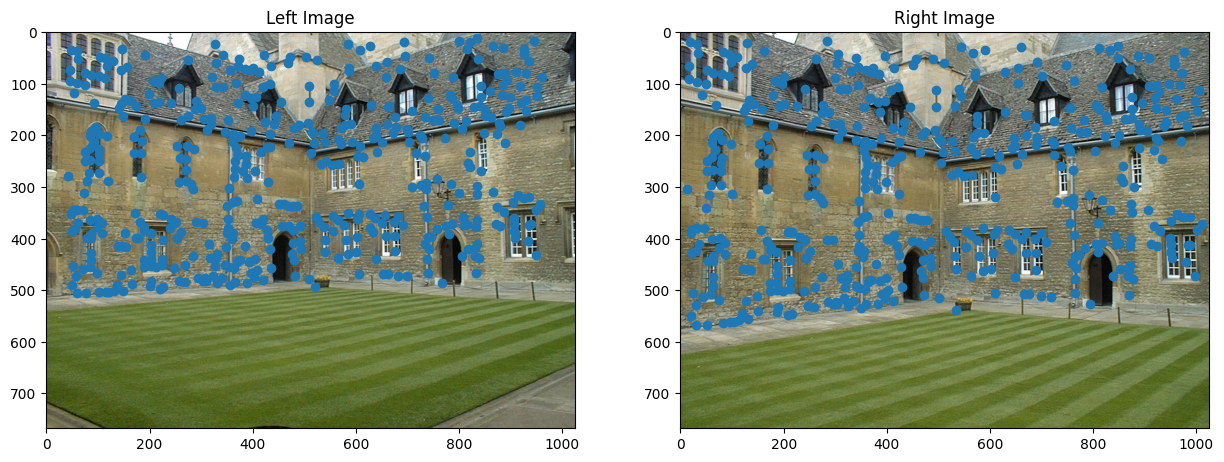

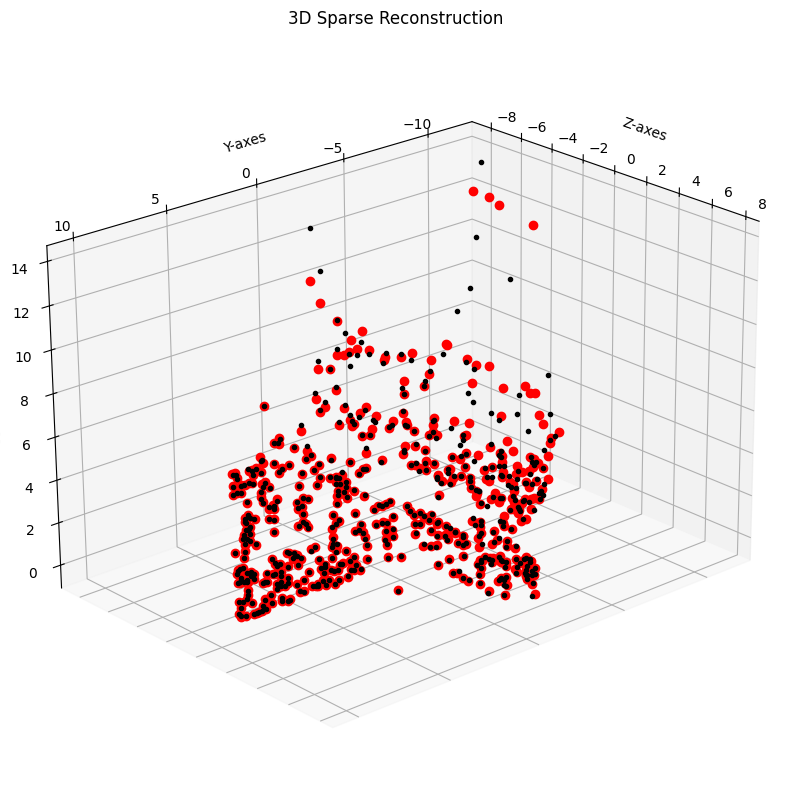

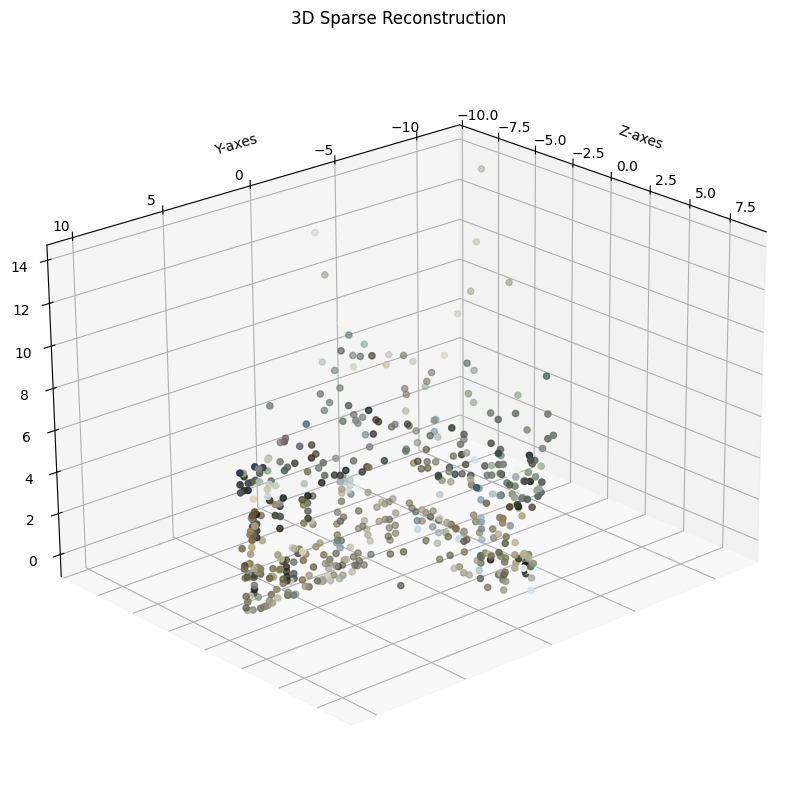

In [5]:
CASE1 = True

if CASE1:
  img_left, img_right, pts_left, pts_right, M_left, M_right, P3D_true = case1()
else:
  img_left, img_right, pts_left, pts_right, M_left, M_right, P3D_true = case2()


# Triangulate the points to obtain 3D coordinates
P3D_est = triangulate(pts_left,pts_right,M_left,M_right)


# Plotting keypoints on left and right images
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax1.imshow(img_left)
ax1.plot(pts_left[0,:],pts_left[1,:],'o')
ax1.title.set_text('Left Image')
ax2 = fig.add_subplot(122)
ax2.imshow(img_right)
ax2.plot(pts_right[0,:],pts_right[1,:],'o')
ax2.title.set_text('Right Image')

if CASE1:


   # Plotting Estimated and True 3D points
   pixel_color = []

   for i in range(pts_left.shape[1]):
      pixel_color.append(img_left[int(pts_left[1,i]),int(pts_left[0,i])])
   pixel_color = np.asarray(pixel_color)

   fig = plt.figure(figsize=(10,10))
   ax = fig.add_subplot(111, projection='3d')
   ax.plot(P3D_true[0],P3D_true[1],P3D_true[2],'ro')
   ax.plot(P3D_est[0],P3D_est[1],P3D_est[2],'k.')
   ax.set_title('3D Sparse Reconstruction')
   ax.set_xlabel('X-axes')
   ax.set_ylabel('Y-axes')
   ax.set_zlabel('Z-axes')
   ax.set_aspect('equal')
   ax.view_init(elev=44,azim=58,roll=-113)

   fig = plt.figure(figsize=(10,10))
   ax = fig.add_subplot(111, projection='3d')
   ax.scatter(P3D_est[0],P3D_est[1],P3D_est[2], c=pixel_color/255.0)
   ax.set_title('3D Sparse Reconstruction')
   ax.set_xlabel('X-axes')
   ax.set_ylabel('Y-axes')
   ax.set_zlabel('Z-axes')
   ax.set_aspect('equal')
   ax.view_init(elev=44,azim=58,roll=-113)

else:
   # Plotting Estimated and True 3D points
   pixel_color = []

   for i in range(pts_left.shape[1]):
      pixel_color.append(img_left[int(pts_left[1,i]),int(pts_left[0,i])])
   pixel_color = np.asarray(pixel_color)

   fig = plt.figure(figsize=(10,10))
   ax = fig.add_subplot(111, projection='3d')
   ax.scatter(P3D_est[0],P3D_est[1],P3D_est[2], c=pixel_color/255.0)
   ax.set_title('3D Sparse Reconstruction')
   ax.set_xlabel('X-axes')
   ax.set_ylabel('Y-axes')
   ax.set_zlabel('Z-axes')
   ax.view_init(elev=30,azim=45)
   ax.set_xlim([-400,400])
   ax.set_ylim([-500,500])
   ax.set_zlim([1000,2000])
   ax.set_aspect('equal')
   ax.view_init(elev=-71,azim=-135,roll=41)




plt.show()